In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# data input
data = pd.read_csv("cal_habs_filled_chl_sst_rrs_all_stations.csv")
data.head

# summing the two Pseudo-nitzschia species
data["Pn_total"] = data["Pn_delicatissima"].add(data["Pn_seriata"], fill_value=0)
data[["Pn_delicatissima", "Pn_seriata", "Pn_total"]]
#print(data["Pn_total"].to_list())

,Pn_delicatissima,Pn_seriata,Pn_total
0,NaN,1600.000,1600.0000
1,28080.0000,35320.000,63400.0000
2,1599.2302,9595.381,11194.6112
3,1252.0000,0.000,1252.0000
4,6358.0000,1122.000,7480.0000
...,...,...,...
649,1496.0000,0.000,1496.0000
650,NaN,NaN,NaN
651,NaN,NaN,NaN
652,38381.5230,2132.307,40513.8300


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Column names of the Rrs bands to combine
wavelength1 = "Rrs_530.0"
wavelength2 = "Rrs_532.0"
rrs_cols = [c for c in data.columns
            if c.startswith("Rrs_") and c[-1].isdigit()]
rrs_cols

# Simple environmental predictors
ENV_VARS = ["sst"] # , "chlor_a"
#ENV_VARS = ["Temp", "Avg_Chloro"]

data2 = data[data["Pn_total"].notna()].copy() #Create copy of data by keeping only rows of data where Np_total has a value (non-NA).

# Create a new column in df for the ratio
Rrs_ratio = f"ndi_{wavelength1}_{wavelength2}"
data2[Rrs_ratio] = (data2[wavelength1] - data2[wavelength2]) / (data2[wavelength1] + data2[wavelength2])

predictors = rrs_cols + ENV_VARS # + rrs_cols  + ["Rrs_689.0", "Rrs_691.0", "Rrs_714.0"] [Rrs_ratio]

# To see what the model would look like without PACE, use:
#predictors = ENV_VARS
X = data2[predictors]
#y = data2["pDA"]
y = np.log10(data2["Pn_total"])

# Get rid of NaNs, BRT gets mad otherwise (Keep only the rows where every column in X is non-NA and non-Inf, and apply the exact same row filtering to y.)
mask = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y)

X = X.loc[mask].copy()
y = y.loc[mask].copy()

print(f"Predictors used: {predictors}")
print(f"Number of samples: {len(y)}")

Predictors used: ['Rrs_346.0', 'Rrs_348.0', 'Rrs_351.0', 'Rrs_353.0', 'Rrs_356.0', 'Rrs_358.0', 'Rrs_361.0', 'Rrs_363.0', 'Rrs_366.0', 'Rrs_368.0', 'Rrs_371.0', 'Rrs_373.0', 'Rrs_375.0', 'Rrs_378.0', 'Rrs_380.0', 'Rrs_383.0', 'Rrs_385.0', 'Rrs_388.0', 'Rrs_390.0', 'Rrs_393.0', 'Rrs_395.0', 'Rrs_398.0', 'Rrs_400.0', 'Rrs_403.0', 'Rrs_405.0', 'Rrs_408.0', 'Rrs_410.0', 'Rrs_413.0', 'Rrs_415.0', 'Rrs_418.0', 'Rrs_420.0', 'Rrs_422.0', 'Rrs_425.0', 'Rrs_427.0', 'Rrs_430.0', 'Rrs_432.0', 'Rrs_435.0', 'Rrs_437.0', 'Rrs_440.0', 'Rrs_442.0', 'Rrs_445.0', 'Rrs_447.0', 'Rrs_450.0', 'Rrs_452.0', 'Rrs_455.0', 'Rrs_457.0', 'Rrs_460.0', 'Rrs_462.0', 'Rrs_465.0', 'Rrs_467.0', 'Rrs_470.0', 'Rrs_472.0', 'Rrs_475.0', 'Rrs_477.0', 'Rrs_480.0', 'Rrs_482.0', 'Rrs_485.0', 'Rrs_487.0', 'Rrs_490.0', 'Rrs_492.0', 'Rrs_495.0', 'Rrs_497.0', 'Rrs_500.0', 'Rrs_502.0', 'Rrs_505.0', 'Rrs_507.0', 'Rrs_510.0', 'Rrs_512.0', 'Rrs_515.0', 'Rrs_517.0', 'Rrs_520.0', 'Rrs_522.0', 'Rrs_525.0', 'Rrs_527.0', 'Rrs_530.0', 'Rrs_53

/srv/conda/envs/notebook/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Boosted Regression Tree setup

First, we’ll split the dataset into training and testing subsets using train_test_split. Here, test_size=0.2 means that 20% of the data are held out for testing, while the remaining 80% are used to train the model. The random_state=42 just fixes the random seed so the split is reproducible; using 42 is arbitrary (the answer to the universe and everything), but it ensures we get the same results every time we run the code. Remove random_state if you want the results to change with every run.



(array([ 2.,  0.,  1.,  8.,  4.,  5., 12., 18., 13., 12., 21., 24., 13.,
        28., 17., 28., 14., 19., 15., 12., 11., 13.,  5.,  9.,  1.,  3.,
         2.,  5.,  2.,  1.]),
 array([2.        , 2.14452262, 2.28904523, 2.43356785, 2.57809047,
        2.72261308, 2.8671357 , 3.01165832, 3.15618093, 3.30070355,
        3.44522617, 3.58974878, 3.7342714 , 3.87879402, 4.02331663,
        4.16783925, 4.31236187, 4.45688448, 4.6014071 , 4.74592972,
        4.89045233, 5.03497495, 5.17949757, 5.32402019, 5.4685428 ,
        5.61306542, 5.75758804, 5.90211065, 6.04663327, 6.19115589,
        6.3356785 ]),
 <BarContainer object of 30 artists>)

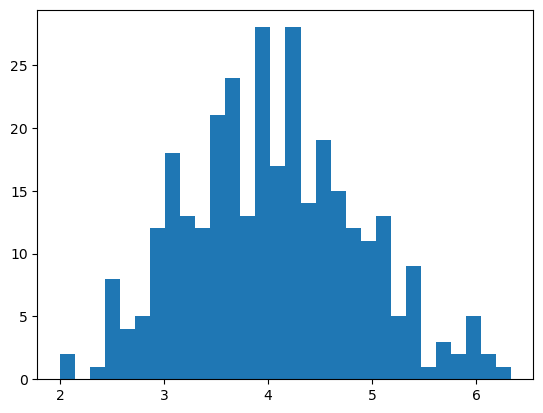

In [16]:
import matplotlib.pyplot as plt

plt.hist(y, bins=30)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_train)

138    4.474978
399    5.090903
398    5.337713
416    3.027820
489    3.957239
         ...   
346    3.504941
370    6.018146
237    3.571888
513    5.672744
572    3.942554
Name: Pn_total, Length: 254, dtype: float64


Next, we’ll set up a boosted regression tree using GradientBoostingRegressor. This model builds an ensemble of many shallow decision trees (n_estimators=800, max_depth=3), added sequentially so that each new tree focuses on correcting errors made by the previous ones. The small learning_rate=0.01 slows the learning process to improve generalization, while subsample=0.8 introduces randomness by training each tree on 80% of the data, which helps reduce overfitting. We again set random_state=42 to keep the model behavior reproducible.

In [13]:
brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=18) # change random_state for a new random train set
#brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8)
brt.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.01
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",800
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

brt = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.05, max_iter=400,
    validation_fraction=0.1, early_stopping=True, random_state=42
).fit(X_train, y_train)

After fitting the model to the training data, we use it to predict the held-out test data. Model performance is then evaluated using Pearson’s correlation coefficient (r), the coefficient of determination (R²), the root mean squared error (RMSE), and the median absolute percent error (MdAPE) giving us a quick sense of how well the model captures both the strength of the relationship and the overall prediction error.

In [19]:
y_pred = brt.predict(X_test) #predictions

r = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)

# For error metrics, let's get back in linear space so we can interpret
#y_test_lin = y_test #for non-log10 
#y_pred_lin = y_pred #for non-log10
y_test_lin = 10 ** y_test #for log10 
y_pred_lin = 10 ** y_pred #for log10 
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mdape = np.median(np.abs((y_pred_lin - y_test_lin) / y_test_lin)) * 100

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")
print(f"BRT RMSE (linear space)   : {rmse_lin:.3f} cells/L")
print(f"BRT MdAPE (linear space)   : {mdape:.1f}%")

BRT Pearson r : 0.178
BRT R²        : 0.025
BRT RMSE (linear space)   : 363069.331 cells/L
BRT MdAPE (linear space)   : 88.6%


In [20]:
y_pred = brt.predict(X_train) #predictions

r = np.corrcoef(y_train, y_pred)[0, 1]
r2 = r2_score(y_train, y_pred)

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")


BRT Pearson r : 0.653
BRT R²        : 0.273


Finally, let’s visualize how well the model is doing and see which predictors the BRT relied on most. We’ll make a scatter plot of observed vs. predicted values as well as a STAR plot of "feature" importance.

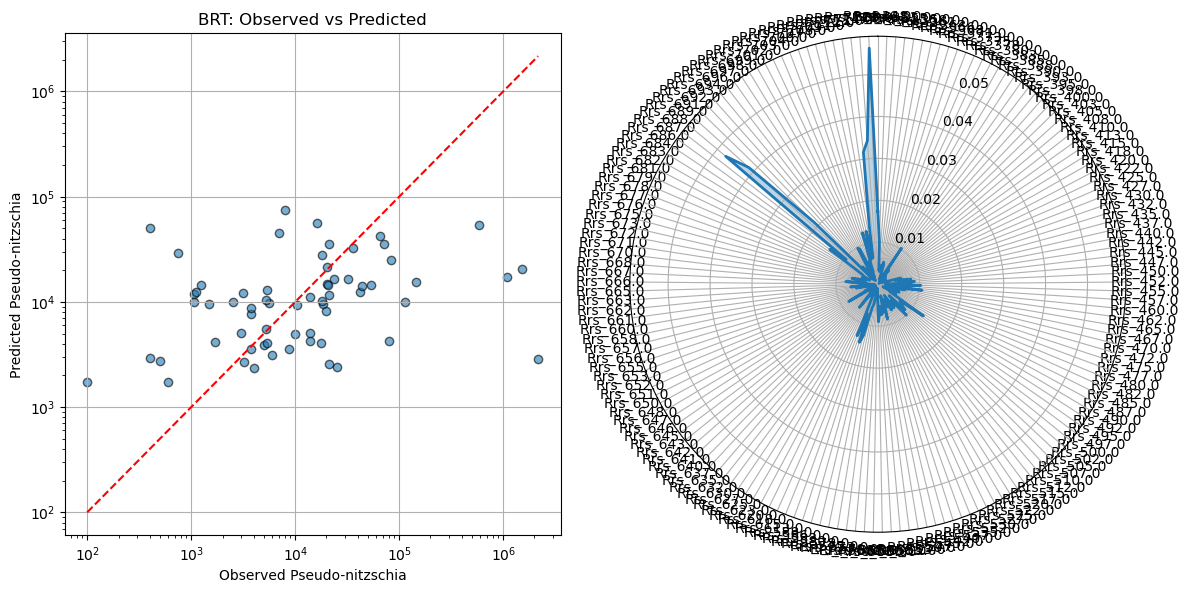

In [15]:
# Prepare data for STAR plot
importances = brt.feature_importances_
importances = importances / importances.sum()
labels = predictors
angles = np.linspace(0, 2 * np.pi, len(importances), endpoint=False)

# Close the loop for polar plot
angles = np.concatenate([angles, angles[:1]])
importances_plot = np.concatenate([importances, importances[:1]])

# Create side-by-side figure
fig = plt.figure(figsize=(12, 6))

# Scatter plot (left)
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_test_lin, y_pred_lin, alpha=0.6, edgecolor="k")
ax1.plot([y_test_lin.min(), y_test_lin.max()], [y_test_lin.min(), y_test_lin.max()], "r--")
ax1.set_xlabel("Observed Pseudo-nitzschia")
ax1.set_ylabel("Predicted Pseudo-nitzschia")
ax1.set_title("BRT: Observed vs Predicted")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)

# Polar plot (right)
ax2 = fig.add_subplot(1, 2, 2, polar=True)
ax2.plot(angles, importances_plot, linewidth=2)
ax2.fill(angles, importances_plot, alpha=0.3)
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(labels)
#ax2.set_title("BRT Feature Importance", pad=25)

plt.tight_layout()
plt.show()



In [10]:
top10 = (
    pd.DataFrame({
        "predictor": predictors,
        "importance": brt.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .head(10)
)

top10



,predictor,importance
169,Rrs_714.0,0.044866
97,Rrs_588.0,0.043817
48,Rrs_465.0,0.029086
171,Rrs_719.0,0.027423
96,Rrs_586.0,0.022469
75,Rrs_532.0,0.021844
149,Rrs_689.0,0.017617
83,Rrs_553.0,0.017606
85,Rrs_558.0,0.016402
16,Rrs_385.0,0.015881


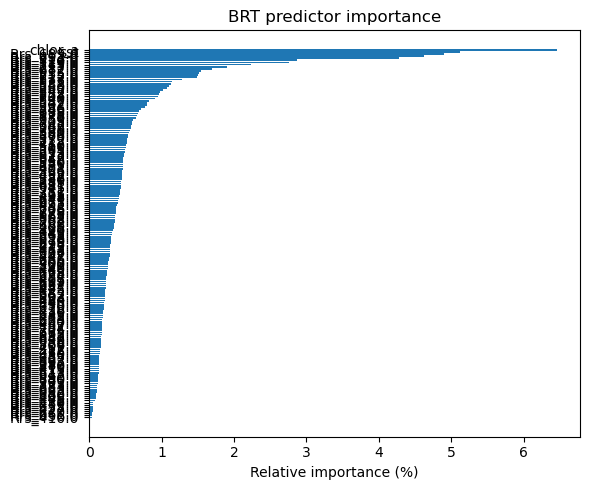

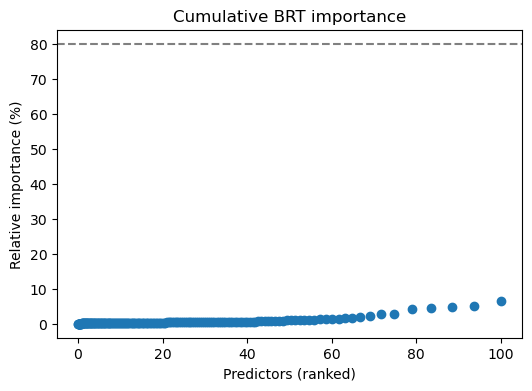

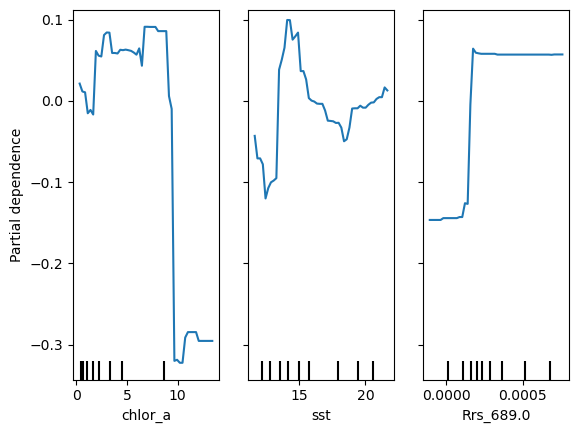

In [14]:
imp = pd.DataFrame({
    "predictor": predictors,
    "importance": brt.feature_importances_
})

# Normalize to %
imp["importance_pct"] = 100 * imp["importance"] / imp["importance"].sum()

# Sort
imp = imp.sort_values("importance_pct", ascending=True)

# Plot
plt.figure(figsize=(6, 5))
plt.barh(imp["predictor"], imp["importance_pct"])
plt.xlabel("Relative importance (%)")
plt.title("BRT predictor importance")
plt.tight_layout()
plt.show()

imp["cumulative"] = imp["importance_pct"].cumsum()

plt.figure(figsize=(6, 4))
plt.plot(imp["cumulative"], imp["importance_pct"], "o")
plt.axhline(80, linestyle="--", color="gray")
plt.ylabel("Relative importance (%)")
plt.xlabel("Predictors (ranked)")
plt.title("Cumulative BRT importance")
plt.show()

from sklearn.inspection import PartialDependenceDisplay

top_vars = imp.sort_values("importance_pct", ascending=False)["predictor"][:3]

PartialDependenceDisplay.from_estimator(
    brt,
    X_train,
    features=top_vars,
    grid_resolution=50
)
plt.show()

In [ ]:
# Residuals

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

residuals = y_train - y_pred

def residual_plot(df_map):
    fig, ax = plt.subplots(
        figsize=(7,5),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # symmetric limits around 0
    res = df_map["residual"].values
    max_abs = np.nanmax(np.abs(res))
    vmin, vmax = -max_abs, max_abs

    ax.coastlines(resolution="110m")
    ax.add_feature(cfeature.LAND, facecolor="0.9")

    sc = ax.scatter(
        df_map["lon"],
        df_map["lat"],
        c=df_map["residual"],
        cmap="coolwarm",
        s=6,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(sc, ax=ax, label="Residual (y - y_pred)")
    bias = df_map["residual"].mean()
    plt.title(f"Residual Map (mean bias = {bias:.3f})")
    plt.show()